### Date: 4 April 2017

Aim: The aim of this notebook is to compare two cost functions

In [1]:
import sys

In [2]:
sys.path.append("../code/")

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

In [4]:
import sys, traceback
from docopt import docopt
import pandas as pd
import time
import numpy as np
import os
np.random.seed(0)

from common_functions import create_region_df, features_dict, create_feature_combinations, create_df_main
from matrix_factorisation import nmf_features, prepare_df_factorisation,prepare_known_features, create_matrix_factorised, create_prediction

## Learning the appliance factors for fridge from Austin regin

In [5]:
year=2014
seed = 0
test_home=26
test_home_list = [test_home]
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['Austin']=1.0
test_region = 'Austin'
feature_list = ['energy','home']
appliance="fridge"
feature_comb = ['None']
lat = 2

In [7]:
def f(year, seed, test_home, train_regions, train_fraction_dict,test_region
              , feature_list, appliance, feature_comb, lat, idx_item=None, data_item=None, cost='absolute'):
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home,
                                                                                     feature_list, seed, 3000, 0)

    idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)

    A = create_matrix_factorised(appliance, test_home, X_normalised)
    X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                        idx_user=idx_user, data_user=data_user,
                         idx_item=idx_item, data_item=data_item, MAX_ITERS=15, cost=cost)
    return X, Y, res, df

In [8]:
from common_functions import *

In [9]:
preds = {}
errors ={}

In [11]:
for appliance in ['wm']:
    df, dfc, X_matrix, X_normalised, col_max, col_min, \
    appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                      train_fraction_dict,
                                                                                     test_region, test_home_list,
                                                                                     feature_list, seed)
    preds[appliance] = {}
    errors[appliance] = {}

    for cost in ['absolute','relative']:
        preds[appliance][cost] = {}
        errors[appliance][cost] = {}
        for lat in range(2, 3):
            print lat, cost, appliance
            X, Y, res, df_austin = f(year, seed, [X_matrix.index[0]], train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
                      "Austin", feature_list, appliance, feature_comb, lat, cost=cost)
            p = pd.DataFrame(Y*X)*3000
            p.index = X_normalised.index
            p.columns = X_normalised.columns

            preds[appliance][cost][lat] = p[appliance_cols]
            
            
            agg = df_austin[aggregate_cols].ix[preds[appliance][cost][lat].index]
            agg.columns = preds[appliance][cost][lat].columns

            gt_appliance = df_austin[appliance_cols].ix[preds[appliance][cost][lat].index]

            gt_fraction = 100*(gt_appliance/agg)
            pred_fraction = 100*(preds[appliance][cost][lat]/agg)
            gt_fraction_dropna = gt_fraction.unstack().dropna()
            pred_fraction_dropna = pred_fraction.unstack().dropna()
            pred_fraction_dropna = pred_fraction_dropna.ix[gt_fraction_dropna.index]

            rms = np.sqrt(mean_squared_error(gt_fraction_dropna, pred_fraction_dropna))
            errors[appliance][cost][lat] = rms

2 absolute wm


ValueError: Length mismatch: Expected axis has 35 elements, new values have 38 elements

In [13]:
p

,0,1,2,3,4,5,6,7,8,9,...,14,15,16,17,18,19,20,21,22,23
0,6.638681,11.880801,11.961625,10.725908,5.130575,5.878254,5.358402,5.497413,5.208828,5.011135,...,705.418419,820.206423,1089.576674,1553.248538,1791.132337,1956.879569,1451.240950,1129.370172,678.232197,791.241134
1,2.219091,2.976422,3.310777,2.803064,1.921857,2.039663,2.056659,1.658389,1.710834,1.881587,...,420.696747,386.997531,456.768345,643.062321,689.479280,803.135734,585.486821,480.195481,459.586465,551.790636
2,5.756844,10.013884,10.173169,9.074125,4.509105,5.119123,4.723689,4.715163,4.508128,4.405430,...,665.377161,744.001483,971.707418,1382.873348,1579.552023,1740.188731,1287.601991,1009.153660,655.726205,769.520314
3,3.236867,5.021008,5.298826,4.622893,2.662028,2.924092,2.818605,2.541391,2.516196,2.603525,...,487.376139,487.438417,603.052626,853.411450,943.721843,1069.724348,785.462655,630.309601,511.337816,608.660274
4,6.593345,12.570321,12.412536,11.258575,4.935297,5.780205,5.116140,5.598686,5.196729,4.816940,...,557.382593,727.209771,1010.441722,1446.699867,1708.597432,1828.091555,1363.574237,1042.120489,493.219982,563.297656
5,4.320983,2.011053,3.831177,2.482512,4.529138,4.255974,5.014712,2.547488,3.216040,4.449416,...,1522.503572,1182.744538,1241.494352,1723.318828,1687.794717,2130.689819,1521.902588,1325.627269,1780.727430,2167.306431
6,3.959957,5.386645,5.960060,5.061205,3.413900,3.634116,3.650020,2.972939,3.055267,3.342066,...,736.749647,682.063258,808.101759,1138.175315,1223.509073,1421.923523,1037.207452,849.141700,802.520231,962.942320
7,8.689149,15.074951,15.327603,13.664982,6.814096,7.729575,7.140315,7.109743,6.803181,6.657600,...,1011.653242,1127.456994,1470.340317,2092.183655,2387.725034,2632.502311,1947.450390,1527.263204,998.996163,1172.918909
8,3.990067,7.119270,7.174485,6.429734,3.088113,3.534640,3.226311,3.300258,3.130024,3.016318,...,427.972565,495.407690,656.870405,936.228534,1078.489818,1179.367310,874.411613,681.006267,412.668771,481.766233
9,6.419745,11.036412,11.254372,10.016352,5.055477,5.718401,5.302467,5.234594,5.023262,4.939820,...,766.260476,844.480423,1095.746468,1558.366300,1773.348688,1960.127484,1449.043351,1138.833460,761.794486,895.834965


In [106]:
pd.DataFrame(errors['wm'])

,absolute,relative
2,2.445439,2.539881
3,2.469430,2.599373
4,2.475764,2.497887
5,2.466054,2.504312
6,2.391985,2.499480
7,2.433001,2.450431
8,2.486937,2.256475
9,2.500988,2.490833


In [87]:
pd.DataFrame(errors['fridge'])

,absolute,relative
2,6.112056,6.407486
3,6.170353,5.363131
4,6.285317,5.282948
5,6.110347,5.680063
6,6.158746,6.338569
7,5.612240,4.202034
8,5.475683,4.766908
9,5.893599,3.704388


In [95]:
from plot_functions import *

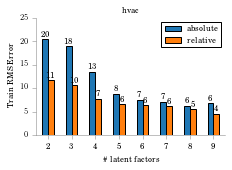

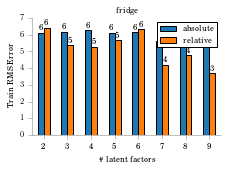

In [104]:
for appliance in ['hvac','fridge']:
    latexify()
    pd.DataFrame(errors[appliance]).plot(kind='bar',rot=0, colors=tableau20blind[::2])
    plt.xlabel("\# latent factors")
    plt.title(appliance)
    plt.ylabel("Train RMS Error")
    ax = plt.gca()
    rects = ax.patches
    autolabel(rects, ax)
    format_axes(ax)
    plt.savefig("../results/cost_%s.png" %appliance, dpi=300, bbox_inches="tight")

In [40]:
gt = X_normalised*3000

In [41]:
gt.head()

,fridge_1,fridge_2,fridge_3,fridge_4,fridge_5,fridge_6,fridge_7,fridge_8,fridge_9,fridge_10,...,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
22,40.065216,38.722286,43.623249,45.221500,50.067524,45.812618,44.945148,51.419483,47.902267,42.785286,...,255.916443,277.545471,308.597168,367.201874,398.430786,439.061493,328.362793,241.123642,265.382141,290.065521
48,27.477316,25.517517,28.414051,28.792150,31.091383,34.986317,33.388767,33.084934,30.447884,NaN,...,219.260925,278.706482,292.433838,380.418182,377.448914,411.127319,360.189880,NaN,NaN,NaN
59,6.026600,5.326834,5.888783,5.785100,6.022916,5.811083,6.067667,6.038017,6.068567,6.176900,...,1104.907593,960.725891,924.203918,1117.204102,1098.265259,1514.582764,1085.488647,968.533325,1364.930664,1792.101440
68,15.675484,25.881584,37.173920,30.078650,30.868483,34.146900,32.208481,30.686283,34.450333,33.623535,...,242.106171,282.852448,291.739075,366.836182,275.163605,296.538025,323.354004,330.055054,291.440002,268.946960
86,44.414917,41.957634,54.030785,57.884884,63.415699,57.771408,68.974884,73.124931,64.749886,69.464485,...,910.495056,892.727905,1539.470215,1766.850586,2164.451904,2057.155029,1615.092407,1355.893921,956.530701,942.771301


In [42]:
pred.head()

,fridge_1,fridge_2,fridge_3,fridge_4,fridge_5,fridge_6,fridge_7,fridge_8,fridge_9,fridge_10,...,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
22,30.270299,16.269799,34.475021,28.491949,41.077506,38.471174,30.575610,40.942653,40.615206,40.769031,...,295.941882,239.002983,378.464100,425.124613,459.067077,510.310993,437.532010,358.821399,316.180041,261.997457
48,23.126776,16.622438,26.830798,24.911088,32.172882,31.540815,27.442809,33.546731,32.468932,33.184829,...,235.354934,245.494730,302.145811,409.366500,457.334130,497.565508,413.765446,337.482211,244.308452,269.903080
59,3.381534,7.297538,4.493839,7.291396,5.620602,7.106188,8.752657,7.536117,6.417662,7.217041,...,45.155232,108.915045,59.266983,158.038216,190.634583,197.771635,152.783124,122.882016,38.907976,120.425543
68,24.179450,12.515082,27.481718,22.398324,32.721522,30.483678,23.954896,32.444355,32.277752,32.331972,...,235.332235,183.695802,300.820248,329.880253,354.464778,395.273654,340.373988,279.353841,252.244925,201.278612
86,42.555081,60.139514,52.836164,67.995016,64.764868,73.183522,79.278658,77.704187,69.886558,75.422129,...,498.299071,895.106744,647.587224,1349.430079,1593.033284,1674.679729,1321.709810,1067.509031,468.891393,988.241591


,fridge_1,fridge_2,fridge_3,fridge_4,fridge_5,fridge_6,fridge_7,fridge_8,fridge_9,fridge_10,...,aggregate_3,aggregate_4,aggregate_5,aggregate_6,aggregate_7,aggregate_8,aggregate_9,aggregate_10,aggregate_11,aggregate_12
22,-0.244474,-0.579834,-0.209710,-0.369947,-0.179558,-0.160249,-0.319713,-0.203752,-0.152124,-0.047125,...,0.156400,-0.138869,0.226402,0.157741,0.152188,0.162277,0.332465,0.488122,0.191414,-0.096765
48,-0.158332,-0.348587,-0.055721,-0.134796,0.034785,-0.098481,-0.178083,0.013958,0.066377,NaN,...,0.073401,-0.119164,0.033211,0.076096,0.211645,0.210247,0.148743,NaN,NaN,NaN
59,-0.438899,0.369958,-0.236882,0.260375,-0.066797,0.222868,0.442508,0.248111,0.057525,0.168392,...,-0.959132,-0.886633,-0.935872,-0.858541,-0.826422,-0.869422,-0.859249,-0.873126,-0.971495,-0.932802
68,0.542501,-0.516448,-0.260726,-0.255341,0.060030,-0.107278,-0.256255,0.057292,-0.063064,-0.038412,...,-0.027979,-0.350560,0.031128,-0.100742,0.288196,0.332961,0.052636,-0.153614,-0.134488,-0.251605
86,-0.041874,0.433339,-0.022110,0.174659,0.021275,0.266778,0.149384,0.062622,0.079331,0.085765,...,-0.452716,0.002665,-0.579344,-0.236251,-0.264002,-0.185924,-0.181651,-0.212690,-0.509800,0.048230
93,-0.215852,-0.078804,-0.046132,-0.028481,0.008199,0.089644,0.050916,0.174450,0.111386,0.155853,...,-0.101108,0.120816,-0.260510,-0.098575,-0.176264,-0.205663,-0.076319,0.000517,-0.232392,-0.072015
94,-0.245331,-0.575058,-0.152102,-0.358654,-0.190165,-0.275042,-0.438717,-0.265097,-0.209853,-0.206561,...,0.238408,-0.040203,0.338185,0.064264,-0.064577,-0.052768,0.084094,0.187971,0.421651,0.399204
101,NaN,NaN,NaN,NaN,NaN,0.081745,0.078621,0.041088,-0.013215,0.054786,...,NaN,NaN,NaN,-0.201823,-0.233135,-0.214797,-0.073663,-0.019135,-0.358466,0.252096
114,-0.108189,-0.200866,0.030495,-0.030811,0.087074,0.134990,-0.073556,0.086554,0.084381,0.011404,...,0.005606,0.055490,-0.196547,-0.087149,-0.174239,-0.201617,-0.105999,-0.059359,0.048373,0.064919
115,1.634284,0.013302,-0.352850,-0.157062,-0.376383,-0.234742,-0.160452,-0.230815,-0.386230,-0.315119,...,-0.641813,0.162576,-0.465200,-0.048420,0.003962,0.272566,-0.044406,0.035828,-0.614445,-0.016126


In [ ]:
X_austin ={}
Y_austin= {}
for appliance in ['fridge','hvac']:
    X_austin[appliance], Y_austin[appliance], res_sd, df_austin = f(year, seed, [22], train_regions, {"Austin":1.0,"Boulder":0,"SanDiego":0}, 
              "Austin", feature_list, appliance, feature_comb, lat)

In [ ]:
from common_functions import valid_homes_data

### Oracle

In [ ]:
year=2014
seed = 0
train_regions = ["Austin","Boulder","SanDiego"]
train_fraction_dict = {region:0 for region in train_regions}
train_fraction_dict['SanDiego']=1.0
test_region = 'SanDiego'
feature_list = ['energy','home']
feature_comb = ['None']
lat = 2

In [ ]:
import sys

In [ ]:
def compute_oracle(lat):
    out_oracle = {}
    for appliance in ['fridge','hvac']:

        out_oracle[appliance] = {}


        for i, test_home in enumerate(valid_homes_data['SanDiego'][appliance][:]):
            #print test_home
            test_home_list=[test_home]
            df, dfc, X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                              train_fraction_dict,
                                                                                             test_region, test_home_list,
                                                                                             feature_list, seed, 3000, 0)

            idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)
            A = create_matrix_factorised(appliance, test_home_list, X_normalised)



            data_items = None
            idx_items = None
            X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                                idx_user=idx_user, data_user=data_user,
                                 idx_item=idx_items, data_item=data_items, MAX_ITERS=10)
            pred_df = create_prediction(test_home, X, Y, X_normalised, appliance,
                                   col_max, col_min, appliance_cols)
            out_oracle[appliance][test_home]=pred_df
    return out_oracle

### Baseline (k-fold on same region, no transfer)

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
def compute_baselines(lat):
    out_baseline = {}
    for appliance in ['fridge','hvac']:
    #for appliance in ['fridge']:

        out_baseline[appliance] = {}
        for reuse_factors in [True, False]:
        #for reuse_factors in [True]:
            out_baseline[appliance][reuse_factors] = {}
            n_splits=3
            kf = KFold(n_splits=n_splits)
            all_homes = valid_homes_data['SanDiego'][appliance][:]
            temp = {}
            for fold, (test_home_idx, train_home_idx) in enumerate(kf.split(all_homes)):
                temp[fold] = {}

                test_home_list = all_homes[test_home_idx]
                train_home_list = all_homes[train_home_idx]
                #print appliance, reuse_factors, test_home_list, fold
                df, dfc, X_matrix, X_normalised, col_max, col_min, appliance_cols, aggregate_cols, static_features, max_f = prepare_df_factorisation(appliance, year, train_regions,
                                                                                                  train_fraction_dict,
                                                                                                 test_region, test_home_list,
                                                                                                 feature_list, seed, 3000, 0)

                idx_user, data_user = prepare_known_features(feature_comb, static_features, X_normalised)
                A = create_matrix_factorised(appliance, test_home_list, X_normalised)

                if reuse_factors:
                    from collections import OrderedDict
                    data_items = OrderedDict()
                    idx_items = OrderedDict()

                    for count in range(X_austin[appliance].shape[0]):
                        data_items['lat_%d' %count] = np.array(X_austin[appliance][count]).flatten()
                        idx_items['lat_%d' %count] = np.array(range(X_austin[appliance][count].size))
                else:

                    data_items = None
                    idx_items = None




                X, Y, res = nmf_features(A=A, k=lat, constant=0.01, regularisation=False,
                                    idx_user=idx_user, data_user=data_user,
                                     idx_item=idx_items, data_item=data_items, MAX_ITERS=10)
                for test_home in test_home_list:
                    pred_df = create_prediction(test_home, X, Y, X_normalised, appliance,
                                           col_max, col_min, appliance_cols)
                    temp[fold][test_home]=pred_df
            for home in all_homes:
                p =[]

                for fold in range(n_splits):
                    if home in pd.DataFrame(temp[fold]).T.index:
                        p.append(pd.DataFrame(temp[fold]).T.ix[home])
                out_baseline[appliance][reuse_factors][home]=pd.DataFrame(p).mean()
    return out_baseline

In [ ]:
ob = {}
ora ={}

In [ ]:
for k in [2,3, 4]:
    print k, "baseline"
    ob[k] = compute_baselines(k)
    print k, "oracle"
    ora[k] = compute_oracle(k)

In [ ]:
pd.DataFrame(out_baseline['fridge'][True]).T

In [ ]:
from common_functions import compute_rmse_fraction

In [ ]:
res = OrderedDict()
for lat in range(2, 5):
    res[lat]=OrderedDict()
    for appliance in ['hvac','fridge']:
        res[lat][appliance] = OrderedDict()
        res[lat][appliance]['Oracle'] = compute_rmse_fraction(appliance, pd.DataFrame(ora[lat][appliance]).T,
                                                                 "SanDiego")[2]
        for reuse_factors in [True, False]:
            if reuse_factors:
                string = "Transferred from Austin"
            else:
                string = "Learnt from SD"
            res[lat][appliance][string] =compute_rmse_fraction(appliance,pd.DataFrame(ob[lat][appliance][reuse_factors]).T,
                                                             "SanDiego")[2]

In [ ]:
%matplotlib inline

In [ ]:
pd.Panel(res)

In [ ]:
pd.DataFrame(res[4])

In [ ]:
pd.DataFrame(res[3])

In [ ]:
pd.DataFrame(res[2])

In [ ]:
from plot_functions import autolabel, latexify, tableau20blind, format_axes
latexify()
r={}
for appliance in ['hvac','fridge']:
    r[appliance]={}
    for l in range(2, 5):
        r[appliance][l]=pd.DataFrame(res[l][appliance]).squeeze()
        
       
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.png",bbox_inches="tight")
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.pdf",bbox_inches="tight")

In [ ]:
for appliance in ['fridge','hvac']:
    ax = pd.DataFrame(r[appliance]).T.plot()
    format_axes(ax)
    ax.set_title(appliance)
    ax.set_xlabel("\#latent factors")
    ax.set_ylabel("RMS error")
    plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer_latent_%s.png" %appliance,bbox_inches="tight")

In [ ]:
from plot_functions import autolabel, latexify, tableau20blind, format_axes
latexify()
ax = pd.DataFrame(res).T[['Oracle','Learnt from SD', 'Transferred from Austin']].plot(kind="line",rot=0, colors=tableau20blind[::2])
plt.ylabel("RMS~error \n(Lower is better)")
plt.legend(loc=3)
rects = ax.patches
autolabel(rects, ax)
format_axes(ax)
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.png",bbox_inches="tight")
#plt.savefig("/Users/nipunbatra/git/scalable-nilm/results/transfer.pdf",bbox_inches="tight")

In [ ]:
difference_fraction = {}
for appliance in ['hvac','fridge']:
    difference_fraction[appliance] = {}
    for reuse_factors in [True, False]:
        if reuse_factors:
            string = "Transferred from Austin"
        else:
            string = "Learnt from SD"
        gtf, prf, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][reuse_factors]).T,
                                                             "SanDiego")
        errors[appliance][string] = (prf-gtf).mean().mean()

In [ ]:
appliance="hvac"
gtf, prf, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][False]).T,
                                                             "SanDiego")

In [ ]:
gtf_au, prf_au, rms = compute_rmse_fraction(appliance,pd.DataFrame(out[appliance][True]).T,
                                                             "SanDiego")

In [ ]:
prf.describe()

In [ ]:
prf_au.describe()

In [ ]:
X_sd ={}
Y_sd= {}
for appliance in ['fridge','hvac']:
    X_sd[appliance], Y_sd[appliance], res_sd, df_austin = f(year, seed, 54, train_regions, {"Austin":0.0,"Boulder":0,"SanDiego":1.0}, 
              "SanDiego", feature_list, appliance, feature_comb, lat)

In [ ]:
pd.DataFrame(X_sd['fridge']).T.describe()

In [ ]:
pd.DataFrame(X_austin['fridge']).T.describe()

In [ ]:
X_fridge = pd.DataFrame({"Austin":np.array(X_fridge_austin).flatten(),'SanDiego':np.array(X_fridge_sd).flatten()})
X_hvac = pd.DataFrame({"Austin":np.array(X_hvac_austin).flatten(),'SanDiego':np.array(X_hvac_sd).flatten()})

In [ ]:
X_fridge[:12].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for fridge")

In [ ]:
X_hvac[6:].plot()
plt.xlabel("Month of year")
plt.ylabel("Latent factors for HVAC")

In [ ]:
X_fridge.plot()

### Using the fridge latent factors from Austin region

In [ ]:
pd.DataFrame(X).head()

In [ ]:
pd.DataFrame(X_fridge_austin).head()

In [ ]:
X_fridge_sd, Y_fridge_sd, res_sd, df_fridge_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "fridge", feature_comb, lat)
X_hvac_sd, Y_hvac_sd, res_sd, df_hvac_sd = f(year, seed, 54, train_regions, {"Austin":0,"Boulder":0,"SanDiego":1}, 
              "SanDiego", feature_list, "hvac", feature_comb, lat)